![logo](./img/LogoLine_horizon_C3S.png)

<br>

# Analysis of September 2020 European Heatwave using ERA5 Climate Reanalysis Data from C3S

In September 2020, a record-breaking heatwave occured in large parts of western Europe, ([see a description here](https://climate.copernicus.eu/september-brings-record-breaking-warm-temperatures-and-low-sea-ice)). The city of Lille in northern France for example experienced its hottest day in September 2020 since records began in 1945. In this tutorial we will analyse this event with data from the [Climate Data Store (CDS)](https://cds.climate.copernicus.eu/) of the [Copernicus Climate Change Service (C3S)](https://climate.copernicus.eu/).

<hr>

## Learning objectives 🧠

1. Understanding what are climatologies and what are they used for.

2. Learning to identify maximum temperatures in a time series.

3. Getting familiarized with different ways to analyze and visualise climatology data.

<hr>

## Target audience 🎯

**Anyone** interested in accessing, manipulating and using climatology data from the Copernicus Climate Data Store (CDS).

<hr>

## Prerequisites and assumed knowledge 🔍
1. **Programming Skills**: Familiarity with programming concepts, particularly in Python, as the tutorial involves using Python libraries like [xarray](https://matplotlib.org/) for dealing with multidimensional arrays and [matplotlib](https://matplotlib.org/) to make visualisations.
   
2. **Familiarity with API Usage**: Understanding of how to use Application Programming Interfaces (APIs) will be useful for accessing data through the CDS API.

3. **Familiarity with multidimensional data structure**: Comprehending what are data dimensions and how they are organized in an array will be helpful.

<hr>

:::{admonition} Difficulty
:class: tip
2/5
:::

<hr>

:::{dropdown} Run the tutorial
:open:
### WEKEO

[WEkEO](https://www.wekeo.eu/) serves as the official platform of the European Centre for Medium-Range Weather Forecasts (ECMWF), offering access to an extensive array of climate data and tools for analysis and visualization. It provides a robust environment for conducting in-depth analysis and exploration of climate-related datasets. To learn more about WEkEO and its offerings, visit their [website](https://www.wekeo.eu/).

[Run this notebook on WEKEO](https://www.wekeo.eu/) 

### Possible Cloud Services

While Kaggle, Binder, and Colab are popular options for running notebooks in the cloud, it's essential to note that these are just a few among many available choices. Each platform has its unique features and capabilities, catering to diverse user needs and preferences.



| **Kaggle** | **Binder** | **Colab** |
|:----------:|:---------:|:--------:|
| [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Randbee/reanalysis-heatwave/blob/master/reanalysis-heatwave.ipynb) | [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/Randbee/reanalysis-heatwave.git/master?labpath=reanalysis-heatwave.ipynb) | [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Randbee/reanalysis-heatwave/blob/master/reanalysis-heatwave.ipynb) |
:::

<hr>

## Outline

1. Libraries
2. Access data with the CDS API
3. Inspect data
4. View daily maximum 2m temperature for September 2020
5. Compare maximum temperatures with climatology

<hr>

## 1. Libraries

If you still haven't done it, you will need to install the Application Programming Interface (API) of the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu/#!/home). This will allow us to programmatically download data.<br>
Check the other libraries that will be imported. If you haven't got any of them installed yet, do it adapting the code below, used to install the `cdsapi` library.

In [ ]:
!pip install cdsapi

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    Note the exclamation mark in the code above. This means the code will run as a shell (as opposed to a notebook) command.</div>

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.<br>
<br>
The library Xarray has dependencies that might need to be installed. For more details on that, please check the [reanalysis tutorial on climatology](https://randbee.github.io/C3SBook/notebooks/reanalysis-climatology/reanalysis-climatology.html).<br>
These are all the python libraries that you will need to import:

In [1]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

<hr>

## 2. Access data with the CDS API

To access data from the CDS, you will need first to [register](https://cds.climate.copernicus.eu/#!/home) at the ADS registration page (if you haven't already done so), [log in](https://cds.climate.copernicus.eu/user/login), and accept the Terms and Conditions at the end of the `Download data` tab.<br>

To obtain data programmatically from the CDS, you will need an API Key that can be found in the [api-how-to page](https://cds.climate.copernicus.eu/api-how-to). Here your key will appear automatically in the black window, assuming you have already registered and logged into the ADS. Your API key is the entire string of characters that appears after `key:`

Now copy your API key into the code cell below, replacing `#######` with your key.

In [2]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '#############'

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [3]:
DATADIR = './'

### Search for data

To search for data, visit the [Climate Data Store](http://cds.climate.copernicus.eu). To facilitate your search you can use keywords, or apply various filters. The data we are going to use in this exercise is the `ERA5 reanalysis data on single levels from 1979 to present`.

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the `Download data` tab. In this tab a form appears in which we will select the following parameters to download. We will choose a subset area of 1x1 degrees, corresponding to a region of around 111km North/South and 72km East/West in Belgium and Northern France, around the city of Lille:

- Product type: `Reanalysis`
- Variable: `2m temperature`
- Year: `all`
- Month: `September`
- Day: `all`
- Time: `all`
- Geographical area: `North: 51`, `East: 4`, `South: 50`, `West: 3`
- Format: `NetCDF`

![logo](./img/Notebook3_data.png)

At the end of the download form, select `Show API request`. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook, like this:

In [4]:
c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': '2m_temperature',
        'year': [
            '1979', '1980', '1981',
            '1982', '1983', '1984',
            '1985', '1986', '1987',
            '1988', '1989', '1990',
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
        ],
        'month': '09',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            51, 3, 50,
            4,
        ],
    },
    f'{DATADIR}NFrance_hourly_Sep.nc')

2024-06-14 13:07:50,366 INFO Welcome to the CDS
2024-06-14 13:07:50,369 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-06-14 13:07:50,490 INFO Request is queued
2024-06-14 13:20:10,063 INFO Request is completed
2024-06-14 13:20:10,065 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data9/adaptor.mars.internal-1718363836.1161494-5307-6-a4a8f45b-664e-4581-8f36-640b02c90357.nc to ./NFrance_hourly_Sep.nc (1.6M)
2024-06-14 13:20:10,792 INFO Download rate 2.1M/s                                                                                        


Result(content_length=1634068,content_type=application/x-netcdf,location=https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data9/adaptor.mars.internal-1718363836.1161494-5307-6-a4a8f45b-664e-4581-8f36-640b02c90357.nc)

<hr>

## 3. Inspect Data

Now that we have downloaded the data, we can inspect it. We have requested the data in `NetCDF` format. This is a commonly used format for **gridded (array-based) scientific data**.<br>
To read and process this data we will make use of the [Xarray](http://xarray.pydata.org/en/stable/) library, an open source project and Python package that makes working with labelled `multi-dimensional arrays` simple and efficient. For more details on `multi-dimensional arrays` please check the [reanalysis tutorial on climatology](https://randbee.github.io/C3SBook/notebooks/reanalysis-climatology/reanalysis-climatology.html).<br>
We will read the data from our NetCDF file into an [xarray.Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

In [6]:
filename = f'{DATADIR}NFrance_hourly_Sep.nc'
# Create Xarray Dataset
ds = xr.open_dataset(filename)

Now we can query our newly created `Xarray dataset`:

In [7]:
ds

<xarray.Dataset> Size: 6MB
Dimensions:    (longitude: 5, latitude: 5, time: 30240)
Coordinates:
  * longitude  (longitude) float32 20B 3.0 3.25 3.5 3.75 4.0
  * latitude   (latitude) float32 20B 51.0 50.75 50.5 50.25 50.0
  * time       (time) datetime64[ns] 242kB 1979-09-01 ... 2020-09-30T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float64 6MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-14 11:19:57 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

We see that the dataset has <u>one variable</u> called `t2m`, which stands for "2 metre temperature", and <u>three dimensions</u>: **longitude**, **latitude** and **time**.

Select the icons to the right of the table above to expand the attributes of the coordinates and data variables. What are the units of the temperature data?

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single variable (which may still be multi-dimensional) and its coordinates. To make the processing of the **t2m** data easier, we convert in into an Xarray data array:

In [8]:
da = ds['t2m']

Let's convert the units of the 2m temperature data from Kelvin to degrees Celsius. The formula for this is simple: degrees Celsius = Kelvin - 273.15

In [9]:
t2m_C = da - 273.15

<hr>

## 4. View daily maximum 2m temperature for September 2020

As a next step, let us visualize the daily maximum 2m air temperature for September 2020. From the graph, we should be able to identify which day in September was hottest in the area around Lille.

First we average over the subset area:

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    The size covered by each data point varies as a function of latitude. We need to take this into account when averaging. One way to do this is to use the cosine of the latitude as a proxy for the varying sizes.</div>

In [10]:
weights = np.cos(np.deg2rad(t2m_C.latitude))
weights.name = "weights"
t2m_C_weighted = t2m_C.weighted(weights)

In [11]:
Lille_t2m = t2m_C_weighted.mean(["longitude", "latitude"])

Now we select only the data for 2020:

In [12]:
Lille_2020 = Lille_t2m.sel(time='2020')

We can now calculate the max daily 2m temperature for each day in September 2020:

In [13]:
Lille_2020_max = Lille_2020.groupby('time.day').max('time')

Let's plot the results in a chart:

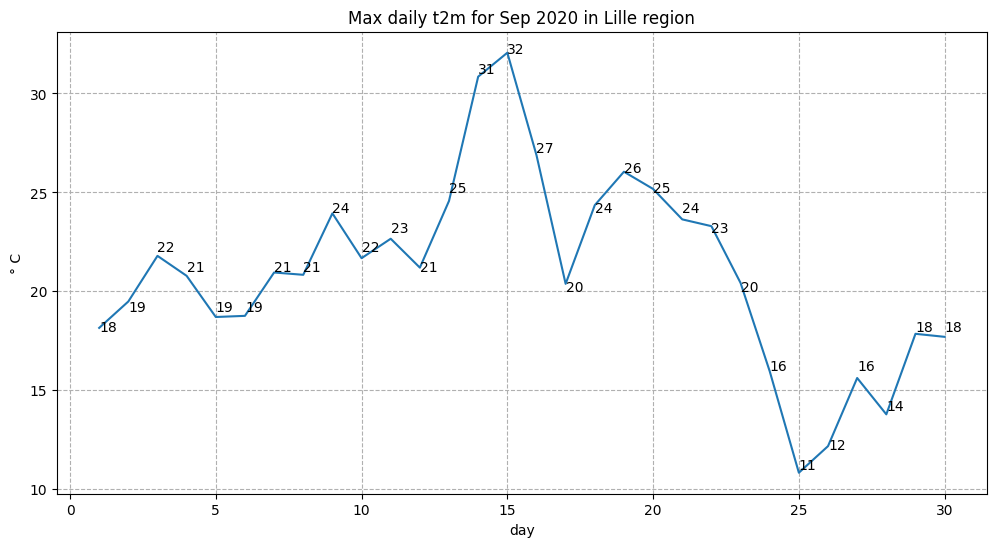

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.plot(Lille_2020_max.day, Lille_2020_max)
ax.set_title('Max daily t2m for Sep 2020 in Lille region')
ax.set_ylabel('° C')
ax.set_xlabel('day')
ax.grid(linestyle='--')
for i,j in zip(Lille_2020_max.day, np.around(Lille_2020_max.values, 0).astype(int)):
    ax.annotate(str(j),xy=(i,j))

In [15]:
print('The maximum temperature in September 2020 in this area was', 
      np.around(Lille_2020_max.max().values, 1), 'degrees Celsius.')

The maximum temperature in September 2020 in this area was 32.1 degrees Celsius.


Which day in September had the highest maximum temperature?

Is this typical for Northern France? How does this compare with the long term average? We will seek to answer 
these questions in the next section.

<hr>

## 5. Compare maximum temperatures with climatology

We will now seek to discover just how high the temperature for Lille in mid September 2020 was when compared with typical values exptected in this region at this time of year. To do that we will calculate the climatology of maximum daily 2m temperature for each day in September for the period of 1979 to 2019, and compare these with our values for 2020.

First we select all data prior to 2020:

In [16]:
Lille_past = Lille_t2m.loc['1979':'2019']

Now we calculate the climatology for this data, i.e. the average values for each of the days in September for a period of several decades (from 1979 to 2019).

To do this, we first have to extract the maximum daily value for each day in the time series:

In [17]:
Lille_max = Lille_past.resample(time='D').max().dropna('time')

We will then calculate various quantiles of the maximum daily 2m temperatures for the 40 year time series for each day in September:

In [18]:
Lille_max_max = Lille_max.groupby('time.day').max()
Lille_max_min = Lille_max.groupby('time.day').min()
Lille_max_mid = Lille_max.groupby('time.day').quantile(0.5)

Let's plot this data. We will plot the, maximum, minimum and 50th quantile of the maximum daily temperature to have an idea of the expected range in this part of France in September, and compare this range with the values for 2020:

/var/folders/kx/ksg5wbrj1sq95rp2tz_72j6c0000gn/T/ipykernel_2793/21074062.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(Lille_2020_max.day, Lille_2020_max, 'bo-', color='darkred', label='Daily max t2m Sep 2020')


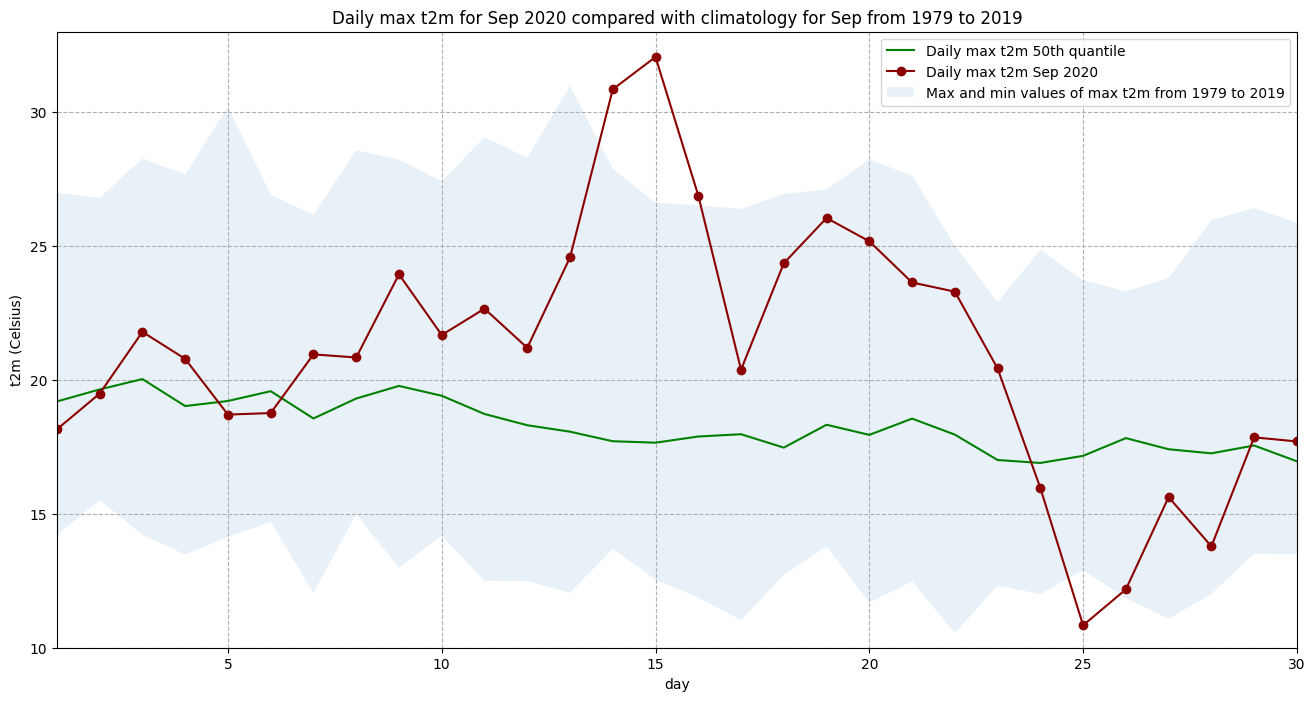

In [19]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot()

ax.plot(Lille_2020_max.day, Lille_max_mid, color='green', label='Daily max t2m 50th quantile')
ax.plot(Lille_2020_max.day, Lille_2020_max, 'bo-', color='darkred', label='Daily max t2m Sep 2020')
ax.fill_between(Lille_2020_max.day, Lille_max_max, Lille_max_min, alpha=0.1, 
                label='Max and min values of max t2m from 1979 to 2019')

ax.set_xlim(1,30)
ax.set_ylim(10,33)
ax.set_title('Daily max t2m for Sep 2020 compared with climatology for Sep from 1979 to 2019')
ax.set_ylabel('t2m (Celsius)')
ax.set_xlabel('day')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

fig.savefig(f'{DATADIR}Max_t2m_clim_Sep_Lille.png')

Interestingly, we see from this plot that while the temperatures from 14 to 16 Sep 2020 were the highest in the ERA5 dataset, on 25 September 2020, the lowest of the maximum temperatures was recorded for this dataset.

We will now look more closely at the probability distribution of maximum temperatures for 15 September in this time period. To do this, we will first select only the max daily temperature for 15 September, for each year in the time series:

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    A propability distribution tells you the likelihood of different temperature values occurring over time, helping you understand patterns, trends and variations in the temperature data.</div>

In [20]:
Lille_max = Lille_max.dropna('time', how='all')
Lille_15 = Lille_max.sel(time=Lille_max['time.day'].isin([15]))


We will then plot the histogram of this:

(array([ 2.,  3., 11.,  6.,  7.,  5.,  1.,  2.,  3.,  1.]),
 array([12.54311547, 13.95037259, 15.35762971, 16.76488683, 18.17214395,
        19.57940107, 20.98665819, 22.39391531, 23.80117243, 25.20842955,
        26.61568667]),
 <BarContainer object of 10 artists>)

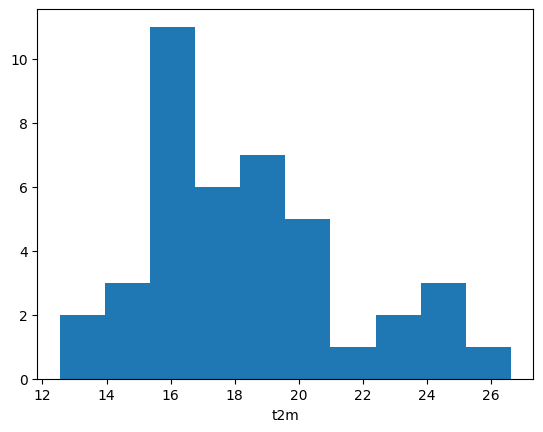

In [21]:
Lille_15.plot.hist()

In this histogram, you see the number of days (all 15 September in the period from 1979 to 2019: y axis) in which a given maximum temperature (x axis) was observed. Has the temperature in this period ever exceeded that of 15 September 2020?

The histogram shows the distribution of maximum temperature of one day in each year of the time series, which corresponds to 41 samples. In order to increase the number of samples, let's plot the histogram of maximum temperatures on 15 September, plus or minus three days. This would increase our number of samples by a factor of seven.

In [22]:
Lille_7days = Lille_max.sel(time=Lille_max['time.day'].isin(range(12, 19)))

The resulting `Lille_7days` dataset contains the maximum temperature data for Lille for the days from the 12th to the 18th of September, inclusive, across all years in the dataset.

Now we can plot the histogram of maximum daily temperatures in the days 12-18 September from 1979-2019:

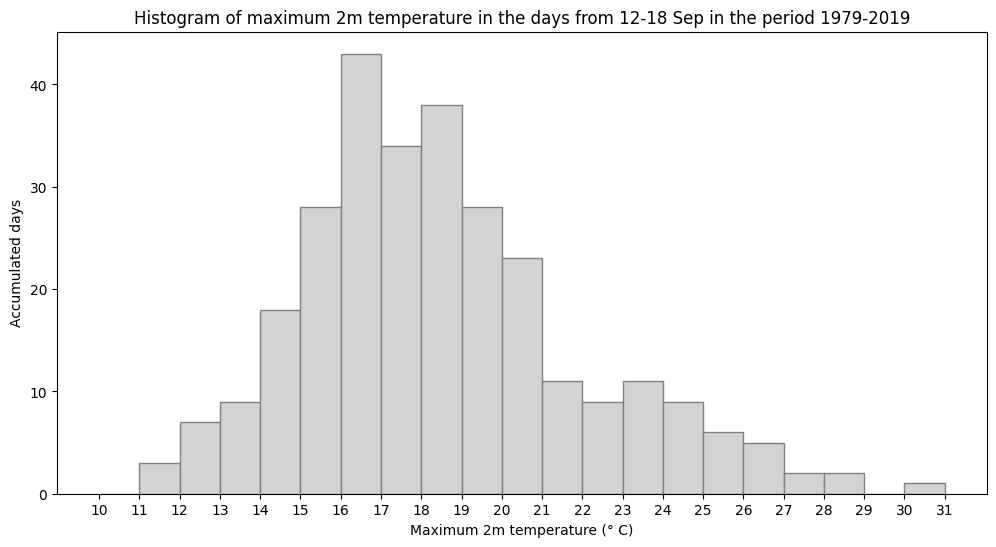

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.hist(Lille_7days, bins = np.arange(10,32,1), color='lightgrey', ec='grey')
ax.set_title('Histogram of maximum 2m temperature in the days from 12-18 Sep in the period 1979-2019')
ax.set_xticks(np.arange(10,32,1))
ax.set_ylabel('Accumulated days')
ax.set_xlabel('Maximum 2m temperature (° C)')

fig.savefig(f'{DATADIR}Hist_max_t2m_mid-Sep_1979-2019.png')

In the histogram above, you see that even if we take an increased sample covering a wider temporal range, the maximum daily temperature still never reached that of 15 September 2020. To increase the sample even further, you could include data from a longer time period. The C3S reanalysis dataset now extends back to 1950 and is accessible here [ERA5 hourly data on single levels from 1950 to 1978 (preliminary version)](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-preliminary-back-extension?tab=overview).

<hr>

## Key Messages to Take Home 📌

- Finding a maximum values of a variable can be easily done using the functions `groupby()`and `max()`.

- By plotting quantiles of a time-averaged variable versus current values of this same variable, one can easily see what values are anomalies compared with the used time frame.

- Anomaly refers to the deviation of a value from the long-term average. Positive or negative anomalies indicate that the average temperatures of a particular year were respectively warmer or cooler than the reference value.

- Histograms of probability distributions are useful to understand patterns and variations in data.

<hr>